In [351]:
import pandas as pd
import os
import re
import seaborn as sns
from matplotlib import pyplot as plt
import sys
import folium
from sklearn.preprocessing import MinMaxScaler

In [352]:
# import data

tri = pd.read_csv("../../data/clean/tri.csv", index_col=0)

/var/folders/37/fsk42jds3255qblrs5r1v99c0000gn/T/ipykernel_24372/3863692259.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  tri = pd.read_csv("../../data/clean/tri.csv", index_col=0)


In [389]:
aqi = pd.read_csv("../../data/clean/aqi.csv")

In [354]:
acs = pd.read_csv("../../data/clean/acs.csv", on_bad_lines='skip')

In [355]:
acs['variable'].value_counts()

variable
total_pop                        16102
total_white                      16102
total_black                      16102
total_american_indian_alaskan    16102
total_hispanic_latino            16102
median_income                    16102
median_gross_rent                16102
median_house_value               16102
income_to_poverty_below_0.5      16102
income_to_poverty_0.5_1          16102
Name: count, dtype: int64

In [356]:
tri.head(3)

,year,facility_name,city,county,state,zip,latitude,longitude,federal_facility,industry_sector,chemical,clean_air_act_chemical,carcinogen,on_site_release_total,one_time_release,production_ratio
0,2000-01-01,CHICAGO AEROSOL LLC,BRIDGEVIEW,COOK,IL,60455,41.739,-87.8106,NO,Hazardous Waste,Xylene (mixed isomers),YES,NO,187.0,0.0,1.17
1,2000-01-01,CHICAGO AEROSOL LLC,BRIDGEVIEW,COOK,IL,60455,41.739,-87.8106,NO,Hazardous Waste,Ethylbenzene,YES,YES,30.0,0.0,1.17
2,2000-01-01,CHICAGO AEROSOL LLC,BRIDGEVIEW,COOK,IL,60455,41.739,-87.8106,NO,Hazardous Waste,Toluene,YES,NO,664.0,0.0,1.07


In [357]:
acs.head(3)

,variable,estimate,moe,acs,xmin,ymin,xmax,ymax,county,state
0,total_pop,72602.0,NaN,2016-2021,-96.961693,39.043257,-96.389046,39.5665,Riley,Kansas
1,total_white,58797.0,457.0,2016-2021,-96.961693,39.043257,-96.389046,39.5665,Riley,Kansas
2,total_black,4509.0,302.0,2016-2021,-96.961693,39.043257,-96.389046,39.5665,Riley,Kansas


In [358]:
aqi.head(3)

,state_code,county_code,latitude,longitude,parameter,year,units,mean,stddev,first_max,second_max,pct_50,pct_50.1,state_name,county_name,city_name
0,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.045114,0.011791,0.074,0.073,0.054,0.046,Alabama,Baldwin,Fairhope
1,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.040624,0.011092,0.066,0.065,0.050,0.042,Alabama,Baldwin,Fairhope
2,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.040624,0.011092,0.066,0.065,0.050,0.042,Alabama,Baldwin,Fairhope


## Data Preprocessing

### ACS Data Aggregation

In [359]:
acs.columns

Index(['variable', 'estimate', 'moe', 'acs', 'xmin', 'ymin', 'xmax', 'ymax',
       'county', 'state'],
      dtype='object')

In [360]:
# keep only relevant years

acs_year_mapping = {
    "2016-2021": 2021,
    "2015-2020": 2020,
    "2014-2019": 2019,
    "2013-2018": 2018,
    "2012-2017": 2017
}

acs['year'] = acs['acs'].map(acs_year_mapping)

In [361]:
acs.dtypes

variable     object
estimate    float64
moe         float64
acs          object
xmin        float64
ymin        float64
xmax        float64
ymax        float64
county       object
state        object
year          int64
dtype: object

In [362]:
acs.head()

,variable,estimate,moe,acs,xmin,ymin,xmax,ymax,county,state,year
0,total_pop,72602.0,NaN,2016-2021,-96.961693,39.043257,-96.389046,39.5665,Riley,Kansas,2021
1,total_white,58797.0,457.0,2016-2021,-96.961693,39.043257,-96.389046,39.5665,Riley,Kansas,2021
2,total_black,4509.0,302.0,2016-2021,-96.961693,39.043257,-96.389046,39.5665,Riley,Kansas,2021
3,total_american_indian_alaskan,602.0,272.0,2016-2021,-96.961693,39.043257,-96.389046,39.5665,Riley,Kansas,2021
4,total_hispanic_latino,6125.0,NaN,2016-2021,-96.961693,39.043257,-96.389046,39.5665,Riley,Kansas,2021


In [363]:
acs['variable'].value_counts()

variable
total_pop                        16102
total_white                      16102
total_black                      16102
total_american_indian_alaskan    16102
total_hispanic_latino            16102
median_income                    16102
median_gross_rent                16102
median_house_value               16102
income_to_poverty_below_0.5      16102
income_to_poverty_0.5_1          16102
Name: count, dtype: int64

In [364]:
# pivoting the acs dataframe to match format
acs = acs.pivot_table(index=['county', 'state', 'year', 'xmin', 'ymin', 'xmax', 'ymax'], 
                              columns='variable', 
                              values='estimate', 
                              aggfunc='first').reset_index()

# checking the transformed dataframe
acs.head()


variable,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0
2,Abbeville,South Carolina,2019,-82.742148,34.013937,-82.239958,34.484002,2711.0,1768.0,681.0,90800.0,38741.0,15.0,6804.0,367.0,24627.0,17221.0
3,Abbeville,South Carolina,2020,-82.742019,34.013925,-82.240171,34.484335,2410.0,1821.0,691.0,100700.0,43090.0,110.0,6690.0,392.0,24582.0,17116.0
4,Abbeville,South Carolina,2021,-82.742019,34.013925,-82.240122,34.484335,2491.0,1581.0,733.0,104100.0,45710.0,37.0,6550.0,415.0,24374.0,16986.0


In [365]:
acs.columns.name = None

In [366]:
acs.head(1)

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0


In [420]:
acs['pct_poverty'] = (acs['income_to_poverty_0.5_1'] + acs['income_to_poverty_below_0.5']) / acs['total_pop']

### TRI Data Aggregation

In [367]:
tri.head(3)

,year,facility_name,city,county,state,zip,latitude,longitude,federal_facility,industry_sector,chemical,clean_air_act_chemical,carcinogen,on_site_release_total,one_time_release,production_ratio
0,2000-01-01,CHICAGO AEROSOL LLC,BRIDGEVIEW,COOK,IL,60455,41.739,-87.8106,NO,Hazardous Waste,Xylene (mixed isomers),YES,NO,187.0,0.0,1.17
1,2000-01-01,CHICAGO AEROSOL LLC,BRIDGEVIEW,COOK,IL,60455,41.739,-87.8106,NO,Hazardous Waste,Ethylbenzene,YES,YES,30.0,0.0,1.17
2,2000-01-01,CHICAGO AEROSOL LLC,BRIDGEVIEW,COOK,IL,60455,41.739,-87.8106,NO,Hazardous Waste,Toluene,YES,NO,664.0,0.0,1.07


In [368]:
# aggregate tri data

tri_grouped = tri.groupby(['county', 'state', 'year']).agg({
    'on_site_release_total': 'sum',
    'one_time_release': 'sum',
    'production_ratio': 'mean'  
}).reset_index()

years_to_include = ['2016', '2017', '2018', '2019', '2020', '2021']
tri_grouped = tri_grouped[tri_grouped['year'].str[:4].isin(years_to_include)]
tri_grouped['year'] = tri_grouped['year'].str[:4].astype(int)

In [369]:
# capitalize the first letter of each word in 'county'
tri_grouped['county'] = tri_grouped['county'].str.title()

# map state abbreviations to full state names
state_mapping = {
    'TX': 'Texas', 'GA': 'Georgia', 'VA': 'Virginia', 'IA': 'Iowa', 'MO': 'Missouri',
    'OH': 'Ohio', 'NC': 'North Carolina', 'IN': 'Indiana', 'IL': 'Illinois', 'KY': 'Kentucky',
    'TN': 'Tennessee', 'MS': 'Mississippi', 'MN': 'Minnesota', 'MI': 'Michigan', 'WI': 'Wisconsin',
    'AL': 'Alabama', 'PA': 'Pennsylvania', 'AR': 'Arkansas', 'KS': 'Kansas', 'NY': 'New York',
    'FL': 'Florida', 'LA': 'Louisiana', 'OK': 'Oklahoma', 'CA': 'California', 'NE': 'Nebraska',
    'SC': 'South Carolina', 'PR': 'Puerto Rico', 'WV': 'West Virginia', 'ID': 'Idaho', 'WA': 'Washington',
    'CO': 'Colorado', 'OR': 'Oregon', 'SD': 'South Dakota', 'ND': 'North Dakota', 'MT': 'Montana',
    'MD': 'Maryland', 'UT': 'Utah', 'NJ': 'New Jersey', 'WY': 'Wyoming', 'NV': 'Nevada',
    'AK': 'Alaska', 'NM': 'New Mexico', 'ME': 'Maine', 'AZ': 'Arizona', 'MA': 'Massachusetts',
    'VT': 'Vermont', 'NH': 'New Hampshire', 'CT': 'Connecticut', 'RI': 'Rhode Island', 'HI': 'Hawaii',
    'DE': 'Delaware', 'MP': 'Northern Mariana Islands', 'VI': 'Virgin Islands', 'AS': 'American Samoa',
    'DC': 'District of Columbia', 'GU': 'Guam'
}

tri_grouped['state'] = tri_grouped['state'].map(state_mapping)

# returning the transformed columns for verification
tri_grouped[['county', 'state']].head()


,county,state
16,Abbeville,South Carolina
17,Abbeville,South Carolina
18,Abbeville,South Carolina
19,Abbeville,South Carolina
20,Abbeville,South Carolina


In [371]:
tri_grouped.reset_index(inplace=True, drop=True)

In [372]:
tri_grouped.head()

,county,state,year,on_site_release_total,one_time_release,production_ratio
0,Abbeville,South Carolina,2016,5632.41,0.0,1.028462
1,Abbeville,South Carolina,2017,24224.63,0.0,0.916923
2,Abbeville,South Carolina,2018,23724.01,0.0,1.866429
3,Abbeville,South Carolina,2019,20348.71,0.0,0.855714
4,Abbeville,South Carolina,2020,16366.51,0.0,1.122222


In [373]:
tri_grouped.shape

(14687, 6)

### AQI Data Aggregation

In [390]:
aqi.head()

,state_code,county_code,latitude,longitude,parameter,year,units,mean,stddev,first_max,second_max,pct_75,pct_50,state_name,county_name,city_name
0,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.045114,0.011791,0.074,0.073,0.054,0.046,Alabama,Baldwin,Fairhope
1,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.040624,0.011092,0.066,0.065,0.050,0.042,Alabama,Baldwin,Fairhope
2,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.040624,0.011092,0.066,0.065,0.050,0.042,Alabama,Baldwin,Fairhope
3,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.040509,0.011027,0.066,0.065,0.050,0.041,Alabama,Baldwin,Fairhope
4,1,3,30.497478,-87.880258,Sample Flow Rate- CV,2016-01-01,Percent,0.080000,0.120451,0.400,0.300,0.200,0.000,Alabama,Baldwin,Fairhope


In [391]:
aqi.dtypes

state_code       int64
county_code      int64
latitude       float64
longitude      float64
parameter       object
year            object
units           object
mean           float64
stddev         float64
first_max      float64
second_max     float64
pct_75         float64
pct_50         float64
state_name      object
county_name     object
city_name       object
dtype: object

In [392]:
aqi.head(3)

,state_code,county_code,latitude,longitude,parameter,year,units,mean,stddev,first_max,second_max,pct_75,pct_50,state_name,county_name,city_name
0,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.045114,0.011791,0.074,0.073,0.054,0.046,Alabama,Baldwin,Fairhope
1,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.040624,0.011092,0.066,0.065,0.050,0.042,Alabama,Baldwin,Fairhope
2,1,3,30.497478,-87.880258,Ozone,2016-01-01,Parts per million,0.040624,0.011092,0.066,0.065,0.050,0.042,Alabama,Baldwin,Fairhope


In [393]:
# check for no differing units
aqi.loc[aqi['parameter'] == "Ozone",:]['units'].value_counts()

units
Parts per million    38705
Name: count, dtype: int64

In [394]:
# check for no differing units
aqi.loc[aqi['parameter'] == "PM2.5 - Local Conditions",:]['units'].value_counts()

units
Micrograms/cubic meter (LC)    71921
Name: count, dtype: int64

In [395]:
# check for no differing units
aqi.loc[aqi['parameter'] == "Sulfur dioxide",:]['units'].value_counts()

units
Parts per billion    15205
Name: count, dtype: int64

In [396]:
aqi.columns

Index(['state_code', 'county_code', 'latitude', 'longitude', 'parameter',
       'year', 'units', 'mean', 'stddev', 'first_max', 'second_max', 'pct_75',
       'pct_50', 'state_name', 'county_name', 'city_name'],
      dtype='object')

In [397]:
# aggregate aqi by parameter

# for 'PM2.5 - Local Conditions'
aqi_pm25 = aqi[aqi['parameter'] == 'PM2.5 - Local Conditions']
aqi_pm25_grouped = aqi_pm25.groupby(['county_name', 'state_name', 'year'])[['mean', 'pct_50', 'latitude', 'longitude', 'stddev', 'first_max', 'second_max', 'pct_75']].mean().reset_index()

# for 'Ozone'
aqi_ozone = aqi[aqi['parameter'] == 'Ozone']
aqi_ozone_grouped = aqi_ozone.groupby(['county_name', 'state_name', 'year'])[['mean', 'pct_50', 'latitude', 'longitude', 'stddev', 'first_max', 'second_max', 'pct_75']].mean().reset_index()

# for 'Sulfur dioxide'
aqi_sulfur_dioxide = aqi[aqi['parameter'] == 'Sulfur dioxide']
aqi_sulfur_dioxide_grouped = aqi_sulfur_dioxide.groupby(['county_name', 'state_name', 'year'])[['mean', 'pct_50', 'latitude', 'longitude', 'stddev', 'first_max', 'second_max', 'pct_75']].mean().reset_index()


In [398]:
# rename columns

aqi_sulfur_dioxide_grouped.rename(columns={'county_name': 'county', 'state_name': 'state'}, inplace=True)
aqi_ozone_grouped.rename(columns={'county_name': 'county', 'state_name': 'state'}, inplace=True)
aqi_pm25_grouped.rename(columns={'county_name': 'county', 'state_name': 'state'}, inplace=True)

In [399]:
aqi_sulfur_dioxide_grouped.head()

,county,state,year,mean,pct_50,latitude,longitude,stddev,first_max,second_max,pct_75
0,Ada,Idaho,2016-01-01,0.800831,0.76,43.600699,-116.347853,0.499580,5.20,4.84,1.04
1,Ada,Idaho,2017-01-01,0.394548,0.30,43.600699,-116.347853,0.346402,4.44,3.52,0.46
2,Ada,Idaho,2018-01-01,0.398352,0.32,43.600699,-116.347853,0.346187,3.86,3.52,0.48
3,Ada,Idaho,2019-01-01,0.455472,0.34,43.600699,-116.347853,0.367493,2.80,2.56,0.66
4,Ada,Idaho,2020-01-01,0.294252,0.24,43.600699,-116.347853,0.346217,18.76,6.48,0.36


In [ ]:
# tri_grouped (total toxic release by county)
# aqi_pm25_grouped, aqi_sulfur_dioxide_grouped, aqi_ozone_grouped (aqi indices by county)
# acs vars: total_pop, total_white, total_black, total_american_indian_alaskan, total_hispanic_latino
#           median_income, median_gross_rent, median_house_value,
#           income_to_poverty_below_0.5, income_to_poverty_0.5_1 
#           income/poverty of 1.0 signifies being at the poverty line, < 0.5 signifies severe poverty, and so on
# tri vars: on_site_release_total emissions (toxic release)
# aqi vars: pm2.5, s02, ozone emissions

# x (predictors):  
# y (target):

In [401]:
print(f"acs cols: {acs.columns}")
print(f"tri cols: {tri_grouped.columns}")
print(f"aqi cols: {aqi_pm25_grouped.columns}")

acs cols: Index(['county', 'state', 'year', 'xmin', 'ymin', 'xmax', 'ymax',
       'income_to_poverty_0.5_1', 'income_to_poverty_below_0.5',
       'median_gross_rent', 'median_house_value', 'median_income',
       'total_american_indian_alaskan', 'total_black', 'total_hispanic_latino',
       'total_pop', 'total_white'],
      dtype='object')
tri cols: Index(['county', 'state', 'year', 'on_site_release_total', 'one_time_release',
       'production_ratio'],
      dtype='object')
aqi cols: Index(['county', 'state', 'year', 'mean', 'pct_50', 'latitude', 'longitude',
       'stddev', 'first_max', 'second_max', 'pct_75'],
      dtype='object')


## Model 1: Understanding Gentrification and Toxic Releases
### Regressing Income on Demographics + Toxic Release 


In [249]:
# prepare data

tri_grouped.head()

,county,state,year,on_site_release_total,one_time_release,production_ratio
16,ABBEVILLE,SC,2016,5632.41,0.0,1.028462
17,ABBEVILLE,SC,2017,24224.63,0.0,0.916923
18,ABBEVILLE,SC,2018,23724.01,0.0,1.866429
19,ABBEVILLE,SC,2019,20348.71,0.0,0.855714
20,ABBEVILLE,SC,2020,16366.51,0.0,1.122222


In [290]:
# merging the dataframes based on 'county', 'state', and 'year' 
# while only keeping the 'on_site_release_total' column from tri_grouped

m1 = acs.merge(tri_grouped[['county', 'state', 'year', 'on_site_release_total']], 
                                on=['county', 'state', 'year'], 
                                how='inner')

m1.head()

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,on_site_release_total
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0,24224.630
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0,23724.010
2,Abbeville,South Carolina,2019,-82.742148,34.013937,-82.239958,34.484002,2711.0,1768.0,681.0,90800.0,38741.0,15.0,6804.0,367.0,24627.0,17221.0,20348.710
3,Abbeville,South Carolina,2020,-82.742019,34.013925,-82.240171,34.484335,2410.0,1821.0,691.0,100700.0,43090.0,110.0,6690.0,392.0,24582.0,17116.0,16366.510
4,Abbeville,South Carolina,2021,-82.742019,34.013925,-82.240122,34.484335,2491.0,1581.0,733.0,104100.0,45710.0,37.0,6550.0,415.0,24374.0,16986.0,14751.315


In [ ]:
m1

In [301]:
# splitting the data into training and testing sets
train_data = m1[m1['year'] <= 2020]
test_data = m1[m1['year'] == 2021]

# defining the feature matrix (X) and target vector (y) for training data
X_train = train_data[['on_site_release_total', 'total_pop', 'total_white', 'total_black', 
                      'total_american_indian_alaskan', 'total_hispanic_latino']]
y_train = train_data['median_income']

# defining the feature matrix (X) and target vector (y) for testing data
X_test = test_data[['on_site_release_total', 'total_pop', 'total_white', 'total_black', 
                    'total_american_indian_alaskan', 'total_hispanic_latino']]
y_test = test_data['median_income']

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((9391, 6), (9391,), (2335, 6), (2335,))

### Train Model

In [302]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

# initializing the linear regression model
model = LinearRegression()

# fitting the model on the training data
model.fit(X_train, y_train)

# model evaluation
# predicting on the training data
y_train_pred = model.predict(X_train)

# calculating R-squared for the training data
r2_train = r2_score(y_train, y_train_pred)

# using cross-validation to get an average R-squared score
avg_r2 = cross_val_score(model, X_train, y_train, cv=5, scoring='r2').mean()

r2_train, avg_r2


(0.2178554216339127, 0.13426849474031383)

In [303]:
# displaying the coefficients for each predictor
coefficients = pd.DataFrame({'Predictor': X_train.columns, 'Coefficient': model.coef_})
print(coefficients)


                       Predictor  Coefficient
0          on_site_release_total     0.000021
1                      total_pop     0.049113
2                    total_white     0.008780
3                    total_black    -0.107611
4  total_american_indian_alaskan    -0.533010
5          total_hispanic_latino    -0.077073


In [307]:
import numpy as np

# taking the natural logarithm of the median_income
X_train_log = np.log1p(X_train)
y_train_log = np.log1p(y_train)  # use log1p to handle cases where income might be 0

# fitting the linear regression model using the log-transformed median_income
model_log = LinearRegression()
model_log.fit(X_train_log, y_train_log)

# displaying the coefficients for each predictor in terms of percent change
coefficients_log = pd.DataFrame({'Predictor': X_train_log.columns, 
                                 'Coefficient (in % change)': model_log.coef_ * 100})  # multiplied by 100 for percentage
coefficients_log

# interpretation: 1% increase in {predictor} leads to a {prediction}% change in median income

,Predictor,Coefficient (in % change)
0,on_site_release_total,0.045101
1,total_pop,-4.418389
2,total_white,18.621512
3,total_black,-3.967491
4,total_american_indian_alaskan,0.908099
5,total_hispanic_latino,-0.697039


## Model 2: Understanding Demographics and Toxic Releases
### Regressing % of People Below Poverty on Demographics, Toxic Releases

In [312]:
# create a new column 'pct_poverty' by summing the two poverty columns and dividing by 'total_pop'
m1['pct_poverty'] = (m1['income_to_poverty_0.5_1'] + m1['income_to_poverty_below_0.5']) / m1['total_pop']

In [313]:
m1.head()

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,on_site_release_total,pct_poverty
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0,24224.630,0.220833
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0,23724.010,0.218802
2,Abbeville,South Carolina,2019,-82.742148,34.013937,-82.239958,34.484002,2711.0,1768.0,681.0,90800.0,38741.0,15.0,6804.0,367.0,24627.0,17221.0,20348.710,0.181874
3,Abbeville,South Carolina,2020,-82.742019,34.013925,-82.240171,34.484335,2410.0,1821.0,691.0,100700.0,43090.0,110.0,6690.0,392.0,24582.0,17116.0,16366.510,0.172118
4,Abbeville,South Carolina,2021,-82.742019,34.013925,-82.240122,34.484335,2491.0,1581.0,733.0,104100.0,45710.0,37.0,6550.0,415.0,24374.0,16986.0,14751.315,0.167063


In [314]:
m1['pct_poverty'].describe()

count    11726.000000
mean         0.147371
std          0.065716
min          0.016820
25%          0.104743
50%          0.136950
75%          0.175494
max          0.650485
Name: pct_poverty, dtype: float64

In [315]:
m1.loc[m1['pct_poverty'] < 0.017, :]

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,on_site_release_total,pct_poverty
7478,Morgan,Utah,2020,-111.876596,40.779948,-111.221484,41.373984,39.0,162.0,1230.0,417600.0,100408.0,16.0,95.0,346.0,11950.0,11374.0,78758.87,0.01682


In [316]:
# splitting the data into training and testing sets
train_data = m1[m1['year'] <= 2020]
test_data = m1[m1['year'] == 2021]

# defining the feature matrix (X) and target vector (y) for training data
X_train = train_data[['on_site_release_total', 'total_pop', 'total_white', 'total_black', 
                      'total_american_indian_alaskan', 'total_hispanic_latino']]
y_train = train_data['pct_poverty']

# defining the feature matrix (X) and target vector (y) for testing data
X_test = test_data[['on_site_release_total', 'total_pop', 'total_white', 'total_black', 
                    'total_american_indian_alaskan', 'total_hispanic_latino']]
y_test = test_data['median_income']

X_train.shape, y_train.shape, X_test.shape, y_test.shape


((9391, 6), (9391,), (2335, 6), (2335,))

### Train Model

In [319]:
import numpy as np

# taking the natural logarithm for x, as y is already in %
X_train_log = np.log1p(X_train)

# fitting the linear regression model using the log-transformed median_income
model_log = LinearRegression()
model_log.fit(X_train_log, y_train)

# displaying the coefficients for each predictor in terms of percent change
coefficients_log = pd.DataFrame({'Predictor': X_train_log.columns, 
                                 'Coefficient (in % change)': model_log.coef_ * 100})  # multiplied by 100 for percentage
coefficients_log

# interpretation: 1% increase in {predictor} leads to a {prediction}% change in % below poverty line

,Predictor,Coefficient (in % change)
0,on_site_release_total,-0.061697
1,total_pop,6.912274
2,total_white,-9.582468
3,total_black,0.705993
4,total_american_indian_alaskan,-0.416602
5,total_hispanic_latino,0.911533


In [342]:
acs.head(3)

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0
2,Abbeville,South Carolina,2019,-82.742148,34.013937,-82.239958,34.484002,2711.0,1768.0,681.0,90800.0,38741.0,15.0,6804.0,367.0,24627.0,17221.0


In [341]:
aqi.head(3)

,state_code,county_code,latitude,longitude,parameter,year,units,mean,pct_50,state_name,county_name,city_name
0,1,3,30.497478,-87.880258,Ozone,2000,Parts per million,0.061870,0.062,Alabama,Baldwin,Fairhope
1,1,3,30.497478,-87.880258,Ozone,2000,Parts per million,0.054953,0.055,Alabama,Baldwin,Fairhope
2,1,3,30.497478,-87.880258,Ozone,2000,Parts per million,0.054953,0.055,Alabama,Baldwin,Fairhope


In [410]:
print([i for i in set(acs["state"])])
len([i for i in set(acs["state"])])

['Kentucky', 'West Virginia', 'Louisiana', 'Massachusetts', 'Minnesota', 'Texas', 'Nevada', 'Wyoming', 'North Carolina', 'Connecticut', 'Tennessee', 'Michigan', 'Maryland', 'Wisconsin', 'Delaware', 'Virginia', 'North Dakota', 'Indiana', 'Utah', 'Rhode Island', 'Montana', 'Kansas', 'Vermont', 'Idaho', 'South Dakota', 'Oklahoma', 'Ohio', 'Alaska', 'Alabama', 'Iowa', 'Colorado', 'Arizona', 'California', 'Hawaii', 'Oregon', 'Washington', 'New Hampshire', 'Arkansas', 'District of Columbia', 'Missouri', 'Maine', 'New Jersey', 'Nebraska', 'Puerto Rico', 'Illinois', 'Florida', 'South Carolina', 'New Mexico', 'Mississippi', 'New York', 'Georgia', 'Pennsylvania']


52

## Model 3: TRI Logistic Regression

### Descriptive Analysis

In [509]:
tri_grouped.head()

,county,state,year,on_site_release_total,one_time_release,production_ratio,is_susceptible
0,Abbeville,South Carolina,2016,5632.41,0.0,1.028462,0
1,Abbeville,South Carolina,2017,24224.63,0.0,0.916923,0
2,Abbeville,South Carolina,2018,23724.01,0.0,1.866429,0
3,Abbeville,South Carolina,2019,20348.71,0.0,0.855714,0
4,Abbeville,South Carolina,2020,16366.51,0.0,1.122222,0


In [538]:
acs['county'].nunique()

1957

In [539]:
tri['county'].nunique()

1725

In [510]:
yearly_avg_release = tri_grouped.groupby('year')['on_site_release_total'].mean()
print(yearly_avg_release)

year
2016    1.295642e+06
2017    1.454841e+06
2018    1.333897e+06
2019    1.210322e+06
2020    1.109902e+06
2021    1.164814e+06
Name: on_site_release_total, dtype: float64


In [511]:
yearly_median_release = tri_grouped.groupby('year')['on_site_release_total'].median()
print(yearly_median_release)

year
2016    51969.6183
2017    50300.7800
2018    47199.7400
2019    44850.6230
2020    40568.6000
2021    41598.8945
Name: on_site_release_total, dtype: float64


In [512]:
release_stats = tri_grouped['on_site_release_total'].describe()
print(release_stats)

count    1.468700e+04
mean     1.261847e+06
std      1.744822e+07
min      0.000000e+00
25%      2.857526e+03
50%      4.535201e+04
75%      3.170495e+05
max      1.082415e+09
Name: on_site_release_total, dtype: float64


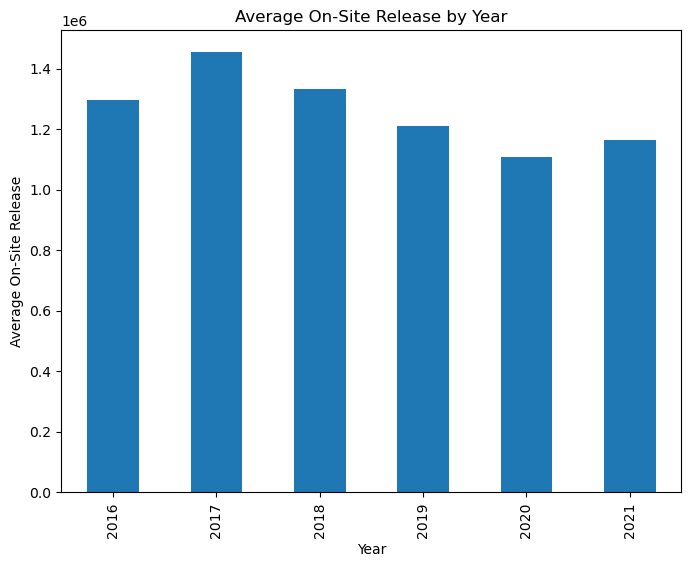

In [513]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
yearly_avg_release.plot(kind='bar', title='Average On-Site Release by Year')
plt.xlabel('Year')
plt.ylabel('Average On-Site Release')
plt.show()


In [514]:
top_counties_by_year = tri_grouped.groupby(['year', 'county'])['on_site_release_total'].sum().reset_index()
top_counties_by_year = top_counties_by_year.sort_values(by=['year', 'on_site_release_total'], ascending=[True, False])
top_counties_by_year = top_counties_by_year.groupby('year').head(1)
print(top_counties_by_year)


      year                    county  on_site_release_total
994   2016  Northwest Arctic Borough           7.769746e+08
2530  2017  Northwest Arctic Borough           1.082415e+09
4069  2018  Northwest Arctic Borough           8.856837e+08
5603  2019  Northwest Arctic Borough           7.692343e+08
7140  2020  Northwest Arctic Borough           5.432828e+08
8672  2021  Northwest Arctic Borough           6.017854e+08


In [520]:
total_release_by_county = tri_grouped.groupby('county')['on_site_release_total'].sum().sort_values(ascending = False)
print(total_release_by_county.head(10))


county
Northwest Arctic Borough    4.659376e+09
Salt Lake                   1.287254e+09
Elko                        7.505210e+08
Humboldt                    5.827539e+08
Juneau City And Borough     3.567031e+08
Eureka                      3.553245e+08
Lander                      3.241652e+08
Gila                        2.885179e+08
Silver Bow                  2.288181e+08
Jefferson                   2.114936e+08
Name: on_site_release_total, dtype: float64


In [547]:
total_release_by_state = tri_grouped.groupby('state')['on_site_release_total'].sum().sort_values(ascending = False)
print(total_release_by_state.head(10))


state
Alaska       5.174836e+09
Nevada       2.312478e+09
Utah         1.433332e+09
Texas        1.034747e+09
Louisiana    7.835335e+08
Indiana      4.653701e+08
Ohio         4.631518e+08
Arizona      4.508789e+08
Tennessee    4.155139e+08
Alabama      3.738410e+08
Name: on_site_release_total, dtype: float64


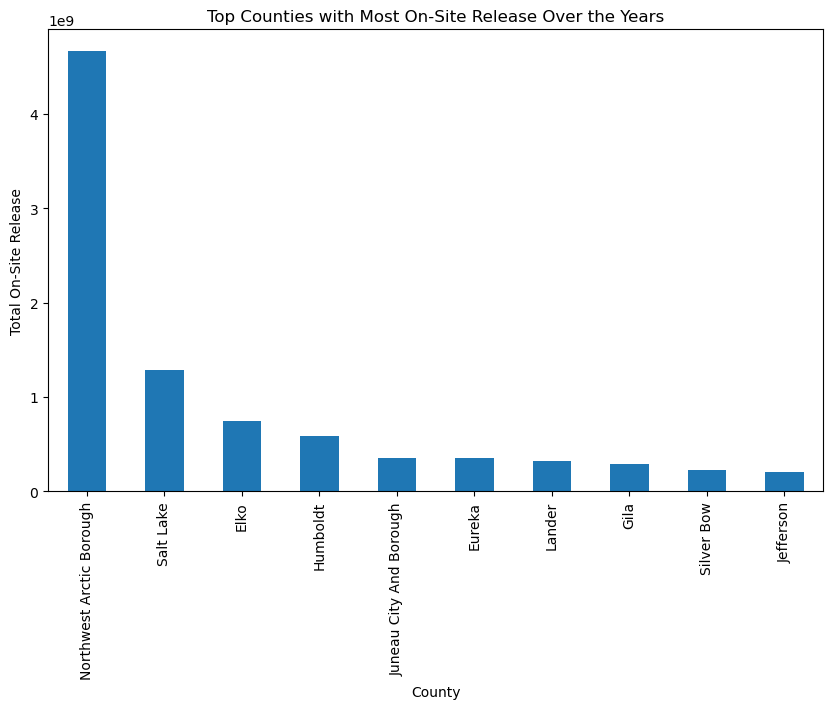

In [517]:
top_counties = total_release_by_county.nlargest(10) 
plt.figure(figsize=(10, 6))
top_counties.plot(kind='bar', title='Top Counties with Most On-Site Release Over the Years')
plt.xlabel('County')
plt.ylabel('Total On-Site Release')
plt.show()


In [521]:
# find top 10 emitting states
emissions_2021 = tri_grouped[tri_grouped['year'] == 2021]

state_emissions_2021 = emissions_2021.groupby('state')['on_site_release_total'].sum()

# get the top 10 emitting states
top_10_emitting_states_2021 = state_emissions_2021.nlargest(10)

print(top_10_emitting_states_2021)

state
Alaska       6.969740e+08
Nevada       4.422410e+08
Utah         1.977081e+08
Texas        1.688354e+08
Louisiana    1.256763e+08
Ohio         7.005253e+07
Indiana      6.447169e+07
Tennessee    6.296485e+07
Arizona      6.133923e+07
Alabama      6.054399e+07
Name: on_site_release_total, dtype: float64


### Data Preparation

In [408]:
tri_grouped.head(2)

,county,state,year,on_site_release_total,one_time_release,production_ratio
0,Abbeville,South Carolina,2016,5632.41,0.0,1.028462
1,Abbeville,South Carolina,2017,24224.63,0.0,0.916923


In [415]:
tri_grouped.dtypes

county                    object
state                     object
year                       int64
on_site_release_total    float64
one_time_release         float64
production_ratio         float64
dtype: object

In [419]:
m1.head(2)

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,on_site_release_total,pct_poverty
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0,24224.63,0.220833
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0,23724.01,0.218802


In [421]:
acs.head(2)

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,pct_poverty
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0,0.220833
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0,0.218802


In [416]:
acs.dtypes

county                            object
state                             object
year                               int64
xmin                             float64
ymin                             float64
xmax                             float64
ymax                             float64
income_to_poverty_0.5_1          float64
income_to_poverty_below_0.5      float64
median_gross_rent                float64
median_house_value               float64
median_income                    float64
total_american_indian_alaskan    float64
total_black                      float64
total_hispanic_latino            float64
total_pop                        float64
total_white                      float64
dtype: object

In [414]:
aqi_pm25_grouped.head(2)

,county,state,year,mean,pct_50,latitude,longitude,stddev,first_max,second_max,pct_75
0,Ada,Idaho,2016-01-01,6.267243,5.25,43.600699,-116.347853,4.746832,26.45,23.50,7.95
1,Ada,Idaho,2017-01-01,8.949138,5.25,43.600699,-116.347853,10.785265,65.85,45.45,9.65


In [417]:
aqi_pm25_grouped.dtypes

county         object
state          object
year           object
mean          float64
pct_50        float64
latitude      float64
longitude     float64
stddev        float64
first_max     float64
second_max    float64
pct_75        float64
dtype: object

In [427]:
aqi_pm25_grouped.head(2)

,county,state,year,mean,pct_50,latitude,longitude,stddev,first_max,second_max,pct_75
0,Ada,Idaho,2016,6.267243,5.25,43.600699,-116.347853,4.746832,26.45,23.50,7.95
1,Ada,Idaho,2017,8.949138,5.25,43.600699,-116.347853,10.785265,65.85,45.45,9.65


In [430]:
aqi_pm25_grouped['mean'].describe()

count    4382.000000
mean        7.590324
std         2.138801
min         0.917162
25%         6.420673
50%         7.602478
75%         8.580078
max        32.238349
Name: mean, dtype: float64

In [437]:
acs.head(2)

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,pct_poverty
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0,0.220833
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0,0.218802


In [436]:
merged_df['mean'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: mean, dtype: float64

In [ ]:
tri_median = tri_grouped['on_site_release_total'].describe()[5]

In [484]:
tri_75 = tri_grouped['on_site_release_total'].describe()[6]

In [492]:
tri_25 = tri_grouped['on_site_release_total'].describe()[4]

In [541]:
# Convert 'year' in aqi_pm25_grouped to "YYYY" format and integer data type
aqi_pm25_grouped['year'] = pd.to_datetime(aqi_pm25_grouped['year']).dt.year

# Create binary target variable in tri_grouped
tri_grouped['is_susceptible'] = (tri_grouped['on_site_release_total'] > tri_median).astype(int)

In [440]:
merged_df.head(2)

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,pct_poverty,mean,is_susceptible
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0,0.220833,NaN,1.0
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0,0.218802,NaN,1.0


In [475]:
merged_df = acs.merge(tri_grouped[['county', 'state', 'year', 'is_susceptible']], on=['county', 'state', 'year'], how='left')

In [476]:
merged_df.isna().sum()

county                              0
state                               0
year                                0
xmin                                0
ymin                                0
xmax                                0
ymax                                0
income_to_poverty_0.5_1             1
income_to_poverty_below_0.5         1
median_gross_rent                  26
median_house_value                 14
median_income                       3
total_american_indian_alaskan       0
total_black                         0
total_hispanic_latino               0
total_pop                           0
total_white                         0
pct_poverty                         1
is_susceptible                   4376
dtype: int64

In [452]:
merged_df.shape

(16102, 19)

In [542]:
# RIGHT MERGE, PRIORITIZE TRI
merged_df_right = acs.merge(tri_grouped[['county', 'state', 'year', 'is_susceptible']], on=['county', 'state', 'year'], how='right')

In [543]:
merged_df_right.isna().sum()

county                              0
state                               0
year                                0
xmin                             2961
ymin                             2961
xmax                             2961
ymax                             2961
income_to_poverty_0.5_1          2961
income_to_poverty_below_0.5      2961
median_gross_rent                2967
median_house_value               2961
median_income                    2961
total_american_indian_alaskan    2961
total_black                      2961
total_hispanic_latino            2961
total_pop                        2961
total_white                      2961
pct_poverty                      2961
is_susceptible                      0
dtype: int64

In [544]:
log_df = merged_df_right.dropna()

In [545]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Selecting predictors and target variable
predictors = ['median_income', 'total_american_indian_alaskan', 'total_black', 'total_hispanic_latino', 'total_pop', 'total_white', 'pct_poverty']
target = 'is_susceptible'

# Splitting the data
X = log_df[predictors]
y = log_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Model
log_reg = LogisticRegression(max_iter=1000)

# Training the Model
log_reg.fit(X_train, y_train)

# Predicting on the Test Set
y_pred = log_reg.predict(X_test)

# Evaluating the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix_1 = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix_1)


Accuracy: 0.9458191126279863
Precision: 0.9458191126279863
Recall: 1.0
F1 Score: 0.9721552291164219
Confusion Matrix:
 [[   0  127]
 [   0 2217]]


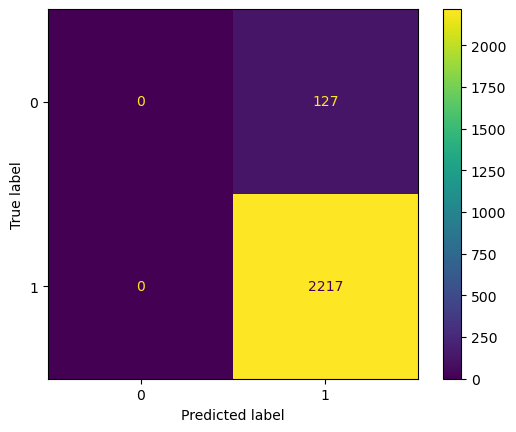

In [546]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_1)
disp.plot()
plt.show()

In [505]:
import statsmodels.api as sm

X_sm = sm.add_constant(X_train)

# fit the model
model = sm.Logit(y_train, X_sm).fit()

# get the summary
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.653941
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:         is_susceptible   No. Observations:                 9376
Model:                          Logit   Df Residuals:                     9368
Method:                           MLE   Df Model:                            7
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                 0.05653
Time:                        04:01:22   Log-Likelihood:                -6131.4
converged:                       True   LL-Null:                       -6498.7
Covariance Type:            nonrobust   LLR p-value:                2.214e-154
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.1040      0.198      5.584      0.

In [460]:
import numpy as np
import statsmodels.api as sm

# Ensure that all values are positive for log transformation
X_train_log = X_train.copy()
for col in X_train_log.columns:
    X_train_log[col] = np.log(X_train_log[col] + 1)  # Adding 1 to avoid log(0)

# Add a constant to the predictors
X_log_sm = sm.add_constant(X_train_log)

# Fit the model
log_model = sm.Logit(y_train, X_log_sm).fit()

# Get the summary
print(log_model.summary())


Optimization terminated successfully.
         Current function value: 0.190124
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         is_susceptible   No. Observations:                 9376
Model:                          Logit   Df Residuals:                     9368
Method:                           MLE   Df Model:                            7
Date:                Fri, 10 Nov 2023   Pseudo R-squ.:                  0.1065
Time:                        03:31:17   Log-Likelihood:                -1782.6
converged:                       True   LL-Null:                       -1995.0
Covariance Type:            nonrobust   LLR p-value:                 1.154e-87
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           -11.0307      4.468     -2.469      0.

In [507]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

# transforming the data for log scale
ln_log_df = log_df.copy()
for col in predictors:
    ln_log_df[col] = np.log(log_df[col] + 1)  # Adding 1 to avoid log(0)

# selecting predictors and target variable
predictors = ['median_income', 'total_american_indian_alaskan', 'total_black', 'total_hispanic_latino', 
              'total_pop', 'total_white', 'pct_poverty']
target = 'is_susceptible'

# splitting the data
X = ln_log_df[predictors]
y = log_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initializing the model
log_reg = LogisticRegression(max_iter=1000)

# training the model
log_reg.fit(X_train, y_train)

# predicting on the test set
y_pred = log_reg.predict(X_test)

# Evaluating the Model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix_1)


Accuracy: 0.6339590443686007
Precision: 0.6214788732394366
Recall: 0.6225749559082893
F1 Score: 0.6220264317180617
Confusion Matrix:
 [[986 224]
 [688 446]]


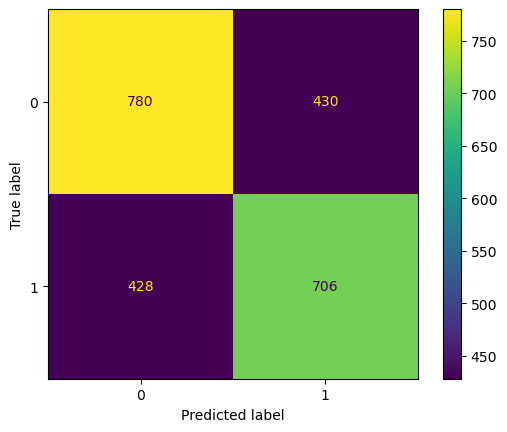

In [508]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

## Predicting PM2.5

In [522]:
aqi_pm25_grouped.head(2)

,county,state,year,mean,pct_50,latitude,longitude,stddev,first_max,second_max,pct_75
0,Ada,Idaho,1970,6.267243,5.25,43.600699,-116.347853,4.746832,26.45,23.50,7.95
1,Ada,Idaho,1970,8.949138,5.25,43.600699,-116.347853,10.785265,65.85,45.45,9.65


In [527]:
acs.head(2)

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,median_house_value,median_income,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,pct_poverty
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,92600.0,35254.0,24.0,6844.0,332.0,24788.0,17269.0,0.220833
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,89000.0,36685.0,0.0,6761.0,347.0,24657.0,17220.0,0.218802


In [535]:
# Merge the two dataframes using an inner join on the common columns (county, state, year)
merged_df_lin = pd.merge(aqi_pm25_grouped, acs, on=['county', 'state', 'year'], how='right')


In [537]:
merged_df_lin.isna().sum()

county                               0
state                                0
year                                 0
mean                             16102
pct_50                           16102
latitude                         16102
longitude                        16102
stddev                           16102
first_max                        16102
second_max                       16102
pct_75                           16102
xmin                                 0
ymin                                 0
xmax                                 0
ymax                                 0
income_to_poverty_0.5_1              1
income_to_poverty_below_0.5          1
median_gross_rent                   26
median_house_value                  14
median_income                        3
total_american_indian_alaskan        0
total_black                          0
total_hispanic_latino                0
total_pop                            0
total_white                          0
pct_poverty              

In [529]:
merged_df_lin.isna().sum()

county                           0.0
state                            0.0
year                             0.0
mean                             0.0
pct_50                           0.0
latitude                         0.0
longitude                        0.0
stddev                           0.0
first_max                        0.0
second_max                       0.0
pct_75                           0.0
xmin                             0.0
ymin                             0.0
xmax                             0.0
ymax                             0.0
income_to_poverty_0.5_1          0.0
income_to_poverty_below_0.5      0.0
median_gross_rent                0.0
median_house_value               0.0
median_income                    0.0
total_american_indian_alaskan    0.0
total_black                      0.0
total_hispanic_latino            0.0
total_pop                        0.0
total_white                      0.0
pct_poverty                      0.0
dtype: float64

In [526]:
merged_df_lin.shape

(4382, 22)

### Other Test Models

In [332]:
# Selecting only 'mean' and merging keys from the aqi dataframes
selected_sulfur = aqi_sulfur_dioxide_grouped[['county', 'state', 'year', 'mean']]
selected_ozone = aqi_ozone_grouped[['county', 'state', 'year', 'mean']]
selected_pm25 = aqi_pm25_grouped[['county', 'state', 'year', 'mean']]

# Renaming 'mean' columns for clarity
selected_sulfur.rename(columns={'mean': 'mean_sulfur'}, inplace=True)
selected_ozone.rename(columns={'mean': 'mean_ozone'}, inplace=True)
selected_pm25.rename(columns={'mean': 'mean_pm25'}, inplace=True)

# Merging m1 with the selected columns from aqi dataframes
merged_with_sulfur = m1.merge(selected_sulfur, on=['county', 'state', 'year'], how='left')
merged_with_ozone = merged_with_sulfur.merge(selected_ozone, on=['county', 'state', 'year'], how='left')
final_merged = merged_with_ozone.merge(selected_pm25, on=['county', 'state', 'year'], how='left')

final_merged.head()


/var/folders/37/fsk42jds3255qblrs5r1v99c0000gn/T/ipykernel_24372/1952832560.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_sulfur.rename(columns={'mean': 'mean_sulfur'}, inplace=True)
/var/folders/37/fsk42jds3255qblrs5r1v99c0000gn/T/ipykernel_24372/1952832560.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_ozone.rename(columns={'mean': 'mean_ozone'}, inplace=True)
/var/folders/37/fsk42jds3255qblrs5r1v99c0000gn/T/ipykernel_24372/1952832560.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

,county,state,year,xmin,ymin,xmax,ymax,income_to_poverty_0.5_1,income_to_poverty_below_0.5,median_gross_rent,...,total_american_indian_alaskan,total_black,total_hispanic_latino,total_pop,total_white,on_site_release_total,pct_poverty,mean_sulfur,mean_ozone,mean_pm25
0,Abbeville,South Carolina,2017,-82.741127,34.013937,-82.239958,34.484002,3102.0,2372.0,616.0,...,24.0,6844.0,332.0,24788.0,17269.0,24224.630,0.220833,NaN,NaN,NaN
1,Abbeville,South Carolina,2018,-82.742148,34.013937,-82.239958,34.484002,3067.0,2328.0,684.0,...,0.0,6761.0,347.0,24657.0,17220.0,23724.010,0.218802,NaN,NaN,NaN
2,Abbeville,South Carolina,2019,-82.742148,34.013937,-82.239958,34.484002,2711.0,1768.0,681.0,...,15.0,6804.0,367.0,24627.0,17221.0,20348.710,0.181874,NaN,NaN,NaN
3,Abbeville,South Carolina,2020,-82.742019,34.013925,-82.240171,34.484335,2410.0,1821.0,691.0,...,110.0,6690.0,392.0,24582.0,17116.0,16366.510,0.172118,NaN,NaN,NaN
4,Abbeville,South Carolina,2021,-82.742019,34.013925,-82.240122,34.484335,2491.0,1581.0,733.0,...,37.0,6550.0,415.0,24374.0,16986.0,14751.315,0.167063,NaN,NaN,NaN


In [339]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# data preparation
X = final_merged.drop(columns=['mean_pm25', 'mean_ozone', 'mean_sulfur'])
y = final_merged['mean_ozone'] 

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# model initialization and training
model_xgb = xgb.XGBRegressor(objective='reg:squarederror')  # Default parameters
model_xgb.fit(X_train, y_train)

# model evaluation
y_pred = model_xgb.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = mse**0.5
print("RMSE:", rmse)

# feature importance
feature_importances = model_xgb.feature_importances_
print("Feature Importances:", feature_importances)


XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/raunakadvani/opt/anaconda3/envs/anly503/lib/libxgboost.dylib, 0x0006): tried: '/Users/raunakadvani/opt/anaconda3/envs/anly503/lib/libxgboost.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Users/raunakadvani/opt/anaconda3/envs/anly503/lib/libxgboost.dylib' (no such file), '/Users/raunakadvani/opt/anaconda3/envs/anly503/lib/libxgboost.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))"]


## Model 3: ARIMAX

## Plots

In [203]:
import folium
from folium.plugins import MarkerCluster, FastMarkerCluster

# Create a base map
m = folium.Map(location=[aqi_pm25_grouped['latitude'].mean(), 
                         aqi_pm25_grouped['longitude'].mean()], zoom_start=5)

# Extract unique years
years = aqi_pm25_grouped['year'].unique()

# Add data for each year
for year in years:
    year_data = aqi_pm25_grouped[aqi_pm25_grouped['year'] == year]
    marker_cluster = MarkerCluster(name=str(year)).add_to(m)
    
    for idx, row in year_data.iterrows():
        folium.CircleMarker(
            location=(row['latitude'], row['longitude']),
            radius=5,
            popup=f"County: {row['county_name']}<br>State: {row['state_name']}<br>Mean AQI: {row['mean']}",
            color="blue",
            fill_color="blue",
            fill_opacity=0.6
        ).add_to(marker_cluster)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Display the map
#m


In [117]:
import folium
from folium.plugins import HeatMapWithTime

grouped_pm25 = aqi_pm25_grouped.groupby(['year', 'latitude', 'longitude']).agg({'mean': 'mean'}).reset_index()

heat_data_pm25 = []
years_pm25 = sorted(grouped_pm25['year'].unique())

for year in years_pm25:
    yearly_data = grouped_pm25[grouped_pm25['year'] == year]
    heat_data_pm25.append([[row['latitude'], row['longitude'], row['mean']] for _, row in yearly_data.iterrows()])


In [204]:
m_pm25 = folium.Map(location=[aqi_pm25_grouped['latitude'].mean(), aqi_pm25_grouped['longitude'].mean()], zoom_start=5)

HeatMapWithTime(heat_data_pm25, index=years_pm25, auto_play=True, max_opacity=0.6, radius=25).add_to(m_pm25)

#m_pm25


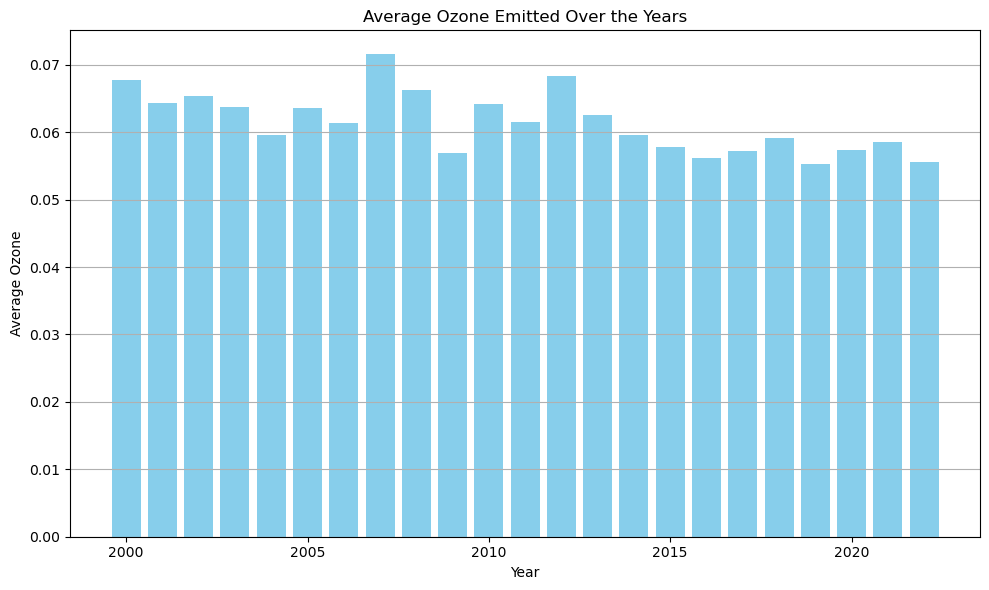

In [121]:
avg_ozone_per_year = aqi_ozone_grouped.groupby('year').agg({'mean': 'mean'}).reset_index()
plt.figure(figsize=(10, 6))
plt.bar(aqi_ozone_grouped['year'], aqi_ozone_grouped['mean'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Average Ozone')
plt.title('Average Ozone Emitted Over the Years')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
avg_ozone_per_year

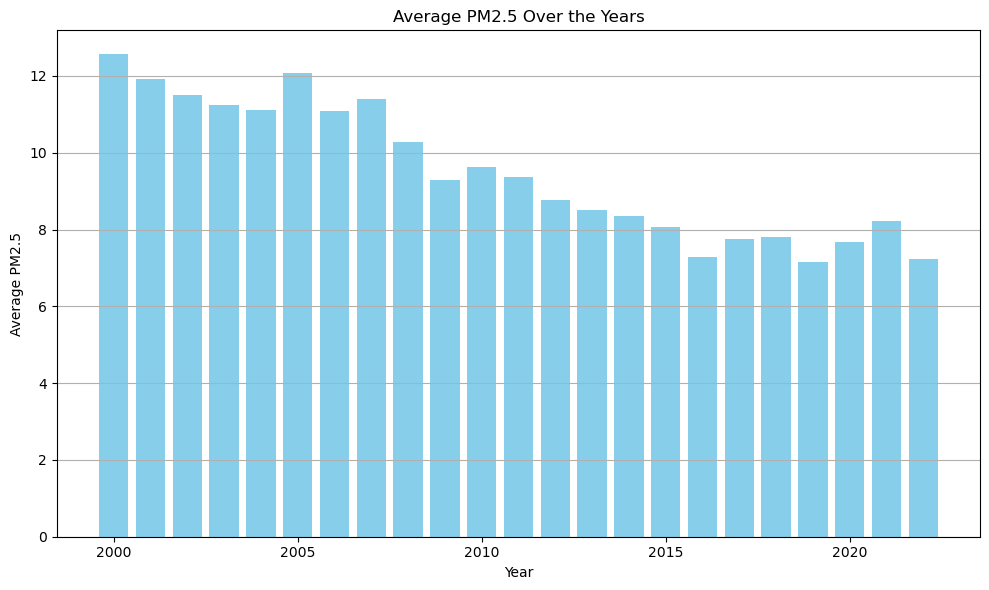

In [206]:
avg_pm25_per_year = aqi_pm25_grouped.groupby('year').agg({'mean': 'mean'}).reset_index()
plt.figure(figsize=(10, 6))
plt.bar(avg_pm25_per_year['year'], avg_pm25_per_year['mean'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Average PM2.5')
plt.title('Average PM2.5 Over the Years')
plt.grid(axis='y')
plt.tight_layout()
plt.show()